### Correlation between news and stock movement

In [1]:
import sys
sys.path.append('..')

#### Load The Datasets Using Modules

In [2]:
from src.data.load_data import load_data #module to load news data
news_df=load_data("../data/raw_analyst_ratings.csv")
news_df.head(5)

read the dataset from ../data/raw_analyst_ratings.csv successfully!


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [3]:
#load yfinance data using load_data module
from src.load_data import load_data

tickers = ["AAPL", "AMZN", "META", "MSFT", "NVDA","GOOG"] #list of ticker for dataset
all_data={}
# load all five datasets 
for t in tickers:
    df=load_data(t)
    all_data[t] = df 


In [4]:
# see the dataset
all_data['AAPL'].head(5)

,Date,Close,High,Low,Open,Volume
0,2009-01-02,2.721686,2.730385,2.554037,2.575630,746015200
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400
3,2009-01-07,2.729484,2.774170,2.706990,2.753477,753048800
4,2009-01-08,2.780169,2.793666,2.700393,2.712090,673500800


#### Date Alignment

In [5]:
#Convert Dates to datetime for news dataset
import pandas as pd
news_df["date"]=pd.to_datetime(news_df['date'],errors="coerce").dt.date

In [6]:

# Convert Date column to datetime first
all_data[t]["Date"] = pd.to_datetime(all_data[t]["Date"], errors='coerce')
# extract the date part
all_data[t]["Date"] = all_data[t]["Date"].dt.date


#### Sentiment Analysis:

In [7]:
# sentiment analysis on news headlines to quantify the tone of each article(positive,nagative and neutral)
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
sia=SentimentIntensityAnalyzer()
news_df["sentiment"]=news_df["headline"].apply(lambda x : sia.polarity_scores(x)['compound'])
news_df["sentiment"].head(5)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\UserK\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


0    0.000
1    0.000
2    0.000
3    0.000
4    0.296
Name: sentiment, dtype: float64

In [8]:
# change the object sentiment in numeric data type to calculate the average
news_df["sentiment"] = pd.to_numeric(news_df["sentiment"], errors="coerce")
# let us get daily averege sentiment 
daily_sentiment=news_df.groupby("date")["sentiment"].mean().reset_index()
daily_sentiment.head(5)

,date,sentiment
0,2011-04-27,0.00000
1,2011-04-28,0.12500
2,2011-04-29,0.36755
3,2011-04-30,0.20230
4,2011-05-01,0.00000


#### Calculate Daily Stock Returns: 

In [9]:
# use our module to get daily return
from src.pre_process import add_returns
for t, df in all_data.items():
    all_data[t] = add_returns(df)


In [10]:
all_data['AAPL'].head(2)

,Date,Close,High,Low,Open,Volume,Return,LogReturn
1,2009-01-05,2.836553,2.884539,2.780469,2.794266,1181608400,0.042204,0.041338
2,2009-01-06,2.789767,2.914229,2.770872,2.877641,1289310400,-0.016494,-0.016632


#### Correlation Analysis:

In [11]:
# merge the two data sets
merged_data = {}

for t in tickers:
    df_stock = all_data[t]

    merged = pd.merge(
        df_stock,
        daily_sentiment,
        left_on="Date",     # stock date column
        right_on="date",    # sentiment date column
        how="inner"
    )

    merged_data[t] = merged


In [12]:
# let us see our merged_data
merged_data['GOOG'].head(5)

,Date,Close,High,Low,Open,Volume,Return,LogReturn,date,sentiment
0,2011-04-27,13.302763,13.311421,13.218408,13.308699,92280599,0.009271,0.009229,2011-04-27,0.000000
1,2011-04-28,13.307957,13.339621,13.211729,13.310184,80299860,0.000390,0.000390,2011-04-28,0.125000
2,2011-04-29,13.459597,13.459597,13.321314,13.358173,169773978,0.011395,0.011330,2011-04-29,0.367550
3,2011-05-02,13.322553,13.499920,13.286932,13.499178,85667905,-0.010182,-0.010234,2011-05-02,0.136444
4,2011-05-03,13.207029,13.407897,13.101648,13.287179,83572079,-0.008671,-0.008709,2011-05-03,0.000000


#### Perform correlation analysis

In [13]:
# correlation analysis
corr = merged_data[t]["sentiment"].corr(merged_data[t]["Return"])
print("Correlation:", corr)

Correlation: 0.024688607333378094


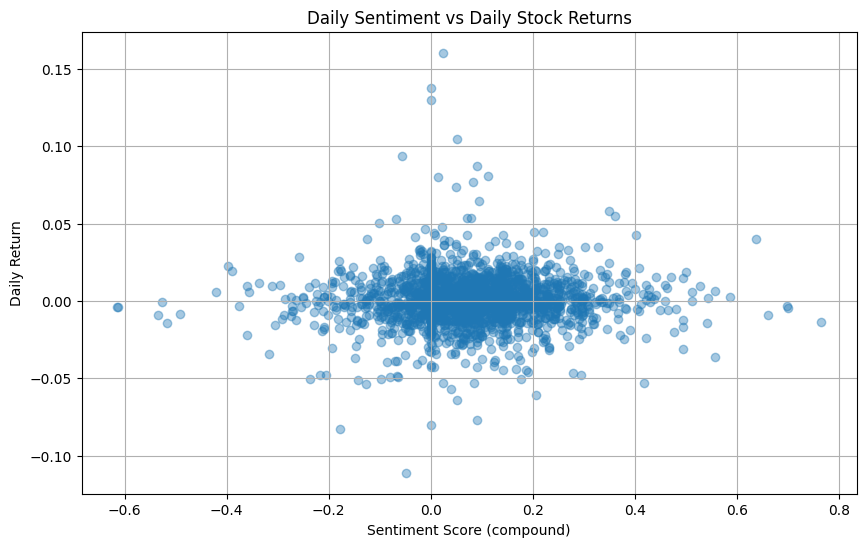

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.scatter(merged_data[t]["sentiment"], merged_data[t]["Return"], alpha=0.4)
plt.title("Daily Sentiment vs Daily Stock Returns")
plt.xlabel("Sentiment Score (compound)")
plt.ylabel("Daily Return")
plt.grid(True)
plt.show()


#### Lagged Correlation (Sentiment impacts tomorrow’s return)

In [15]:
# SHIFT sentiment forward → today's news → tomorrow's return
merged_data[t]["sentiment_lag1"] = merged_data[t]["sentiment"].shift(1)

corr_lag1 = merged_data[t]["sentiment_lag1"].corr(merged_data[t]["Return"])
corr_lag1


np.float64(-0.014457412171124968)